# **Clustering based Course Recommender System**


## Objectives


* Part 1. Perform k-means clustering on the original user profile feature vectors
* Part 2. Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
* Part 3. Perform k-means clustering on the PCA transformed main components
* Part 4. Generate course recommendations based on other group members' enrollment history

----

Previously on `P3_Content_User_Profile_Recommender` notebook, on part 1 we have generated user profile vectors `profile_df` based on course ratings and genres.
The first 5 rows of the dataframe is shown below.


In [1]:
import pandas as pd
user_profile_df = pd.read_csv('user_profile.csv')

# Displaying the first few rows of the DataFrame to inspect its contents
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,83.0,21.0,8.0,68.0,4.0,49.0,0.0,47.0,66.0,3.0,27.0,41.0,9.0,8.0
1,4,78.0,5.0,6.0,48.0,0.0,30.0,0.0,45.0,46.0,0.0,12.0,9.0,0.0,4.0
2,5,47.0,18.0,36.0,46.0,0.0,59.0,0.0,47.0,29.0,4.0,27.0,49.0,7.0,13.0
3,7,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,8,13.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,13.0,0.0,5.0,0.0,0.0,0.0


On part 2, we have also generated course recommendations based on a user's profile and course genres.

Furthermore, we could perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests. For example, in the below user clusters, we have user clusters whom have learned courses related to machine learning, cloud computing, databases, and web development, etc.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_3/images/userprofiles_clustering.png)


For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning.

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.


In this notebook, will be implementing some clustering-based recommender system algorithms.


----


## Part 1. Perform K-means clustering algorithm on the user profile feature vectors

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
# also set a random state
rs = 123

We have already loaded the `user_profile_df`


In [4]:
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,83.0,21.0,8.0,68.0,4.0,49.0,0.0,47.0,66.0,3.0,27.0,41.0,9.0,8.0
1,4,78.0,5.0,6.0,48.0,0.0,30.0,0.0,45.0,46.0,0.0,12.0,9.0,0.0,4.0
2,5,47.0,18.0,36.0,46.0,0.0,59.0,0.0,47.0,29.0,4.0,27.0,49.0,7.0,13.0
3,7,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,8,13.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,13.0,0.0,5.0,0.0,0.0,0.0


we can then list the feature names, they are the user interested topics (course genres):


In [5]:
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

In [6]:
user_profile_df.shape

(33901, 15)

As we can see from the user profile dataset, we have about 33K unique users with interests in areas like ``Database``, ``Python``, ``CloudComputing``, etc. Then, let's check the  summary statistics for each feature.


In [7]:
user_profile_df.describe()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000,33901.000000
mean,1.064064e+06,7.408366,4.665290,3.214802,4.866553,1.335005,4.153181,0.002301,6.893956,6.379812,0.676440,1.373942,3.027433,0.420460,1.356686
std,4.972578e+05,10.210756,5.697474,5.219930,6.426724,3.175841,6.252663,0.096521,7.035741,9.668413,1.550372,3.179992,5.789729,1.829718,2.681439
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.813480e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.043907e+06,4.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.451159e+06,11.000000,9.000000,5.000000,8.000000,0.000000,5.000000,0.000000,11.000000,10.000000,0.000000,0.000000,4.000000,0.000000,3.000000
max,2.103039e+06,86.000000,26.000000,51.000000,68.000000,23.000000,59.000000,5.000000,47.000000,78.000000,10.000000,27.000000,75.000000,21.000000,20.000000


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [8]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
# Instantiating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])

# Printing the mean and standard deviation of the standardized features
for i,j in zip(user_profile_df[feature_names].mean(), user_profile_df[feature_names].std() ):
    print(f'mean {i:.4f} and standard deviation {j:.4f}')

mean -0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000
mean 0.0000 and standard deviation 1.0000
mean -0.0000 and standard deviation 1.0000


The normalized user profile features are:


In [9]:
features = user_profile_df[user_profile_df.columns[1:]]
features 

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,7.403247,2.867051,0.916731,9.823726,0.839159,7.172540,-0.023838,5.700414,6.166582,1.498733,8.058649,6.558706,4.689064,2.477555
1,6.913560,0.058748,0.533578,6.711675,-0.420369,4.133791,-0.023838,5.416147,4.097960,-0.436315,3.341586,1.031595,-0.229798,0.985796
2,3.877501,2.340494,6.280867,6.400470,-0.420369,8.771883,-0.023838,5.700414,2.339631,2.143749,8.058649,7.940484,3.595984,4.342252
3,-0.333806,-0.818847,-0.615880,-0.134838,-0.420369,-0.664236,-0.023838,-0.979862,-0.246147,-0.436315,-0.432065,-0.522905,-0.229798,-0.505962
4,0.547630,-0.818847,-0.615880,0.798778,-0.420369,-0.664236,-0.023838,-0.979862,0.684733,-0.436315,1.140290,-0.522905,-0.229798,-0.505962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.333806,0.058748,0.342002,0.643175,-0.420369,-0.664236,-0.023838,0.015072,-0.659871,-0.436315,2.083702,0.858873,-0.229798,0.612857
33897,-0.725556,-0.818847,-0.041151,-0.757248,-0.420369,-0.664236,-0.023838,-0.979862,-0.659871,-0.436315,-0.432065,-0.522905,-0.229798,-0.505962
33898,-0.333806,0.760824,1.108307,-0.757248,-0.420369,2.854317,-0.023838,0.725740,-0.659871,-0.436315,1.140290,-0.522905,-0.229798,-0.505962
33899,-0.725556,-0.818847,-0.615880,-0.757248,-0.420369,0.135435,-0.023838,-0.979862,-0.659871,-0.436315,-0.432065,-0.522905,-0.229798,-0.505962


We can also save the user ids for later recommendation tasks:


In [10]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
user_ids.head()

,user
0,2
1,4
2,5
3,7
4,8


With the user profile dataset ready, we can use the `KMeans` class provided by scikit-learn library to perform clustering on the user profile feature vectors.


For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`, i.e., the inertia:


In [11]:
num_clusters = [i for i in range(2, 30)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=rs)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia


In [12]:
inertia = kmeans_inertia(num_clusters, features)
inertia

[399858.3119077113,
 354308.1576988321,
 320186.0332135024,
 287648.95593982,
 262889.3184200423,
 240086.75809444027,
 221665.2719386135,
 209228.49329103128,
 197456.87881457288,
 188667.1693762805,
 181290.20948041463,
 175346.47707637917,
 170119.88042795978,
 165245.97585465893,
 160403.63987440465,
 156883.42844220885,
 153687.75383075004,
 150600.67697157554,
 148231.13501949824,
 146122.58598857955,
 143602.806442507,
 141016.4660799453,
 139184.9971112044,
 137327.29979352132,
 135832.83652216493,
 134508.31086571235,
 132688.05335811584,
 130945.3062649213]

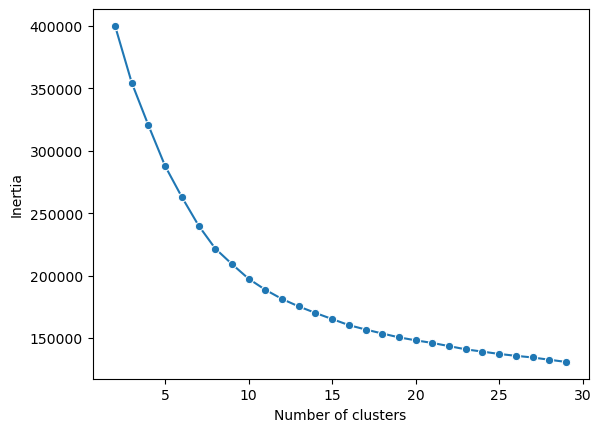

In [13]:
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

From the elbow plot, we visualy identify the point where the metric starting to be flatten, ~20, which indicates the optimized number of clusters.


Once the best number of clusters is identified, we can apply `KMeans()` again to generate cluster label for all users.


In [14]:
cluster_labels = []

kms20 = KMeans(20, random_state=rs)
kms20.fit(features)
cluster_labels = kms20.labels_
print('Unique labels:', np.unique(cluster_labels))


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [15]:
cluster_labels

array([10, 10,  6, ...,  4,  1,  1], dtype=int32)

The cluster labels just generated is a list of integers indicating cluster indices. One may use the following utility method to combine the cluster labels and user ids to a dataframe, so that each cluster a user belongs is known:


In [16]:
def combine_cluster_labels(user_ids, labels):
    # Convert labels to a DataFrame
    labels_df = pd.DataFrame(labels)
    # Merge user_ids DataFrame with labels DataFrame based on index
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    # Rename columns to 'user' and 'cluster'
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [17]:
cluster_labels_df = combine_cluster_labels(user_ids, cluster_labels)
cluster_labels_df

,user,cluster
0,2,10
1,4,10
2,5,6
3,7,1
4,8,15
...,...,...
33896,2102054,5
33897,2102356,1
33898,2102680,4
33899,2102983,1


Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.


----

### Part 2. Apply PCA on user profile feature vectors to reduce dimensions


In the previous step, we applied `KMeans` on the original user profile feature vectors which have 14 original features (the course genres).


In [18]:
# Extracting features from the user_profile_df DataFrame, excluding the 'user' column
features = user_profile_df.loc[:, user_profile_df.columns != 'user']

# Extracting user IDs from the user_profile_df DataFrame
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']

# Creating a list of feature names by excluding the 'user' column name
feature_names = list(user_profile_df.columns[1:])

In [19]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


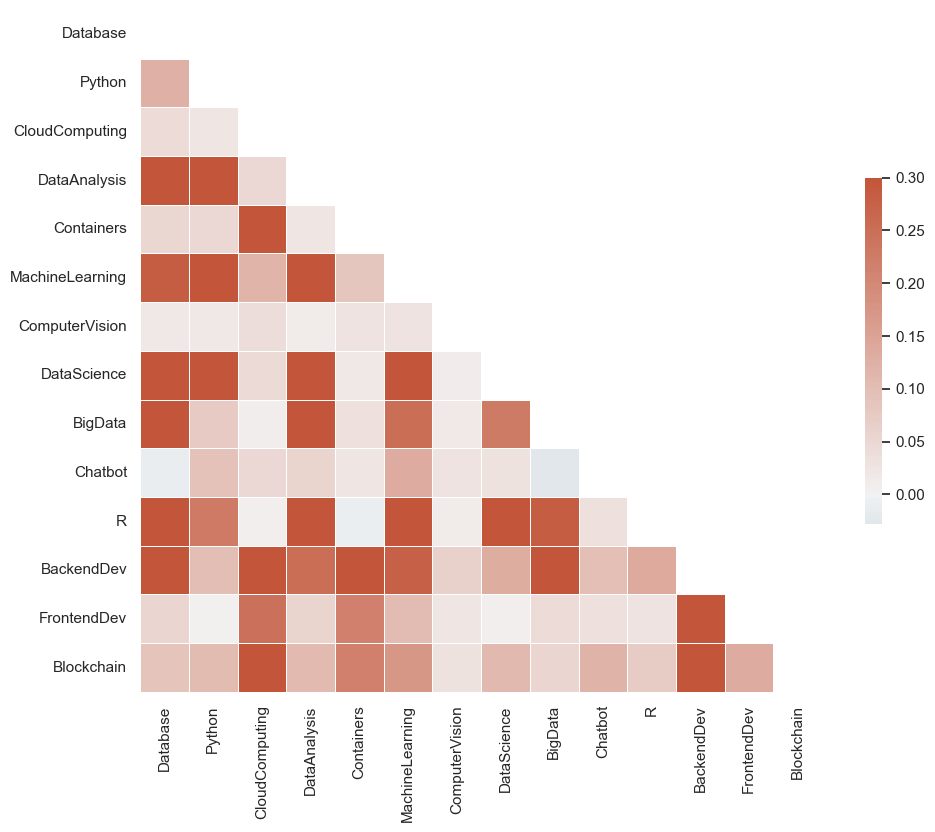

In [20]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = features.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix).

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.


Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


Note that when calling the  `PCA()` class, there is also an import argument called `n_components` which indicates how many components you want to keep in the PCA result. One way to find an optimized `n_components` is to do a grid search on a list of argument candidates (such as `range(1, 15)`) and calculate the ratio of the accumulated variance for each candidate.

If the accumulated variances ratio of a candidate `n_components` is larger than a threshold, e.g., 90%, then we can say the transformed `n_components` could explain about 90% of variances of the original data variance and can be considered as an optimized components size.


In [21]:
features.head()

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,7.403247,2.867051,0.916731,9.823726,0.839159,7.172540,-0.023838,5.700414,6.166582,1.498733,8.058649,6.558706,4.689064,2.477555
1,6.913560,0.058748,0.533578,6.711675,-0.420369,4.133791,-0.023838,5.416147,4.097960,-0.436315,3.341586,1.031595,-0.229798,0.985796
2,3.877501,2.340494,6.280867,6.400470,-0.420369,8.771883,-0.023838,5.700414,2.339631,2.143749,8.058649,7.940484,3.595984,4.342252
3,-0.333806,-0.818847,-0.615880,-0.134838,-0.420369,-0.664236,-0.023838,-0.979862,-0.246147,-0.436315,-0.432065,-0.522905,-0.229798,-0.505962
4,0.547630,-0.818847,-0.615880,0.798778,-0.420369,-0.664236,-0.023838,-0.979862,0.684733,-0.436315,1.140290,-0.522905,-0.229798,-0.505962


In [22]:
def feature_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)

    print("Variance explained with {0} components:".format(n_components),
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

pca_full, mnist_data_full = feature_pca(features, 14)


Variance explained with 14 components: 1.0


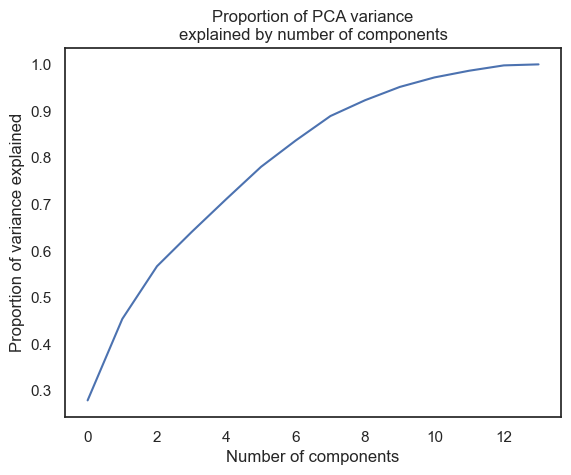

In [23]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We see that with `n_component` equal to 8 we explian about 90% of the variances of the original data with 14 features.
Now we can apply PCA on the user profile feature vectors and reduce the  14 features into `n_component`=8.


In [24]:
pca = PCA(n_components=8)
fit_pca = pca.fit(features)


In [25]:
#np.cumsum(fit_pca.explained_variance_ratio_)
transformed_features =fit_pca.transform(features)

In [26]:
transformed_features_df = pd.DataFrame(data=transformed_features,columns=['PC0','PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
transformed_features_df = pd.concat( [user_ids,transformed_features_df], axis=1)
print(transformed_features_df.shape)
transformed_features_df.head()

(33901, 9)


,user,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,2,19.784206,-1.469351,1.598475,2.072965,-2.444284,1.608192,0.380252,2.592222
1,4,11.333977,-4.172989,2.571778,-0.823700,0.487363,-0.556268,0.735730,0.929047
2,5,17.529097,2.935102,-3.057617,1.590135,-1.881803,0.577718,2.308339,4.142788
3,7,-1.631910,-0.394297,0.731315,-0.005586,-0.034315,0.204048,0.011482,-0.018821
4,8,-0.150156,-1.111714,1.550002,-0.068126,0.045932,0.079516,0.059609,0.953881


----

### Part 3. Perform k-means clustering on the PCA transformed feature vectors


Now, we have the PCA components of the original profile vectors. We can perform k-means on them again:


In [27]:
kmodel = KMeans(8, random_state=rs)
kmodel.fit(transformed_features_df)
cluster_labels = kmodel.labels_
print('Unique labels:', np.unique(cluster_labels))
cluster_labels.shape


Unique labels: [0 1 2 3 4 5 6 7]


(33901,)

In [28]:
cluster_labels_df = combine_cluster_labels(user_ids, cluster_labels)
cluster_labels_df

,user,cluster
0,2,3
1,4,3
2,5,3
3,7,3
4,8,3
...,...,...
33896,2102054,7
33897,2102356,7
33898,2102680,7
33899,2102983,7


Now all users find their learning interest groups, either based on their original or the PCA transformed user profile features.


When a user is in a group or a community, it is very likely that the user will be interested in the courses enrolled by other members within the same group.


----

### Part 4. Generate course recommendations based on the popular courses in the same cluster


The Intuition of clustering-based course recommendation is very simple and can be illustrated via the following example:


Suppose a user has joined a machine learning group (via clustering algorithm). In the group, he/she finds that the top-3 courses enrolled by all other group members are `Machine Learning for Everyone`, `Machine Learning with Python`, `Machine Learning with Scikit-learn`. Since the user has already completed the `Machine Learning for Everyone` earlier, he/she decides to trust the group members' choices and enroll in other two unselected courses `Machine Learning with Python` and `Machine Learning with Scikit-learn`.


In summary, the clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group.

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.


Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:


In [29]:
ratings_df = pd.read_csv('ratings.csv')
print(ratings_df.shape)
ratings_df.head()

(233306, 3)


,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


Next, let's sample a test dataset, containing test users to whom we want to make course recommendations.

In [30]:
np.random.seed(rs)
test_uesrs = np.random.choice(ratings_df['user'].unique(), size=1000, replace=False)

The test users dataset has only two columns, the user id and the enrolled course id.

In [31]:
test_users_df = ratings_df[ratings_df['user'].isin(test_uesrs)][['user', 'item']] # here the ratings will not be needed.
test_users_df.head()

,user,item
15,1474302,DS0103EN
51,687207,ST0101EN
137,1897257,CNSC02EN
155,1805227,DV0101EN
188,759038,BD0111EN


In [32]:
print('number of users in the test dataset:', len(test_users_df['user'].unique()))

number of users in the test dataset: 1000


In [33]:
print('number of items in the test dataset:', len(test_users_df['item'].unique()))

number of items in the test dataset: 104


For each user, let's find its cluster label using the k-means results you have performed in previous steps, assuming it is named `cluster_df`.


You can assign the cluster label to all test users via merging the clustering labels (`cluster_df`:):


In [34]:
test_users_labelled = pd.merge(test_users_df, cluster_labels_df, left_on='user', right_on='user') 
test_users_labelled

,user,item,cluster
0,1474302,DS0103EN,4
1,1474302,DS0101EN,4
2,1474302,DS0105EN,4
3,1474302,PY0101EN,4
4,1474302,DA0101EN,4
...,...,...,...
6640,1718581,CNSC02EN,2
6641,1799755,DAI101EN,2
6642,512095,DS0101EN,5
6643,365797,ST0101EN,5


From the above dataframe, we know each user's enrolled courses and its cluster index.


If we use a `groupby`  and `sum` aggregation, we can get the enrollments count for each course in each group


In [35]:
courses_cluster_grouped = pd.DataFrame(test_users_labelled.groupby(['cluster','item']).size(),columns=['enrollments']).reset_index().rename_axis(index=None, columns=None)
courses_cluster_grouped

,cluster,item,enrollments
0,0,BC0101EN,52
1,0,BC0201EN,18
2,0,BC0202EN,5
3,0,BD0101EN,62
4,0,BD0111EN,46
...,...,...,...
624,7,SC0103EN,1
625,7,SC0105EN,3
626,7,SECM03EN,1
627,7,ST0101EN,7


For each test user, we find any unseen courses based on the popular courses in his/her cluster to recommend.
We also chose a threshold number of courses with a minimum of 20 enrollments.


In [55]:

users = set(test_users_labelled['user'].unique() )
items = set(test_users_labelled['item'].unique() )
clusters = cluster_labels_df[ cluster_labels_df['user'].isin(users) ]
threshold = 20

ux = []
cx = []
recommended = []
numb = []

for user in users:
  user_current_enrolled = set(test_users_labelled['item'][test_users_labelled['user'] == user].unique() )
  user_not_enrolled = items.difference(user_current_enrolled)
  cluster = clusters[clusters['user'] == user]['cluster'].iloc[0]
  mask = ((courses_cluster_grouped['cluster'] == cluster) & (courses_cluster_grouped['item'].isin(user_not_enrolled) ) & (courses_cluster_grouped['enrollments'] >= threshold))
  list_item = courses_cluster_grouped[mask]['item'].values
  ux.append(user)
  cx.append(cluster)
  recommended.append(list_item)
  numb.append(len(list_item))

data_user = {
    'user': ux,
    'cluster': cx,
    'recommended_number': numb,
    'recommended_courses': recommended}

df_1 = pd.DataFrame(data=data_user)


In [56]:
#pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

df_1.sort_values(by='recommended_number',ascending=False).head(20)

,user,cluster,recommended_number,recommended_courses
623,1033458,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
135,1022205,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
330,938601,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
701,1074551,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
580,971918,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
859,904909,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
461,895893,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
39,1089593,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
395,1047316,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"
521,979987,6,23,"[BC0101EN, BC0201EN, BD0101EN, BD0111EN, BD0141EN, BD0211EN, CB0103EN, CL0101EN, CO0101EN, CO0201EN, DA0101EN, DS0101EN, DS0103EN, DS0105EN, DS0301EN, DV0101EN, ML0101ENv3, ML0115EN, ML0122ENv1, PY0101EN, RP0101EN, SC0101EN, ST0101EN]"


With the recommendation results, we need to answer the following two questions:

- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.

In [57]:
df_1.describe(include='all')

,user,cluster,recommended_number,recommended_courses
count,1.000000e+03,1000.00000,1000.000000,1000
unique,NaN,NaN,NaN,979
top,NaN,NaN,NaN,[CC0101EN]
freq,NaN,NaN,NaN,8
mean,1.049213e+06,3.46700,10.980000,NaN
std,4.964586e+05,2.32902,5.884746,NaN
min,9.000000e+00,0.00000,0.000000,NaN
25%,6.699710e+05,1.00000,7.000000,NaN
50%,1.023115e+06,4.00000,11.000000,NaN
75%,1.438584e+06,6.00000,15.000000,NaN


From the dataframe's description, we can see that about 11 courses are recommended per user.

In [64]:
# To collect the most recommended courses, we collect them in a list and count the 10 most recoommended courses

courses_1 = df_1['recommended_courses'].values

courses_flat = []
for x in courses_1:
    for y in x:
        courses_flat.append(y)

df_2 = pd.DataFrame(pd.Series(courses_flat).value_counts()[:10], columns=['Count'])
df_2 = df_2.reset_index().rename_axis(index=None, columns=None).rename(columns={"index": "COURSE_ID"})
df_2 

,COURSE_ID,Count
0,DS0103EN,677
1,BD0111EN,628
2,BD0211EN,617
3,ML0115EN,579
4,DA0101EN,571
5,DS0105EN,567
6,BD0101EN,564
7,PY0101EN,533
8,DS0101EN,533
9,ST0101EN,510


To find the names of those courses, we need to load the `course_genres_df` dataset to extract the names from the `COURSE_ID`.

In [46]:
course_genres_df = pd.read_csv('course_genre.csv')

In [65]:
mask = course_genres_df['COURSE_ID'].isin(pd.Series(courses_flat).value_counts()[:10].axes[0].values)
df_3 = course_genres_df[mask][['COURSE_ID','TITLE']].reset_index(drop=True)

pd.merge(df_2,df_3, left_on='COURSE_ID', right_on='COURSE_ID')

,COURSE_ID,Count,TITLE
0,DS0103EN,677,data science methodology
1,BD0111EN,628,hadoop 101
2,BD0211EN,617,spark fundamentals i
3,ML0115EN,579,deep learning 101
4,DA0101EN,571,data analysis with python
5,DS0105EN,567,data science hands on with open source tools
6,BD0101EN,564,big data 101
7,PY0101EN,533,python for data science
8,DS0101EN,533,introduction to data science
9,ST0101EN,510,statistics 101


And that is the list of the 10-most recommended courses.

----

In the next notebook, we perform KNN and NMF-based collaborative filtering on the user-item interaction matrix. For this we are going to use the *Surprise*. *Surprise* is a Python sci-kit library for recommender systems.